# RF superconducting qubit readout 101

This example shows a basic demonstration of reading out an emulated qubit, including measurements of single shot readout fidelity, T1, and Rabi oscillation.

In [1]:
import sys
# sys.path.append('../qick/qick_lib/')
sys.path.append('../soft/')
sys.path.append('../firmware/')

from hist_analysis import *
from qick import *
from qick_training import *

from qick.averager_program import QickSweep
from qick.averager_program import QickRegister
from qick.averager_program import merge_sweeps

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from tqdm.notebook import tqdm
from random import *
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import cauchy

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Initialize Firmware.
soc = QickTrainingSoc('../firmware/qick_training.bit')

# Print information.
soccfg = soc
print(soc)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.268
	Firmware timestamp: Wed Sep  6 15:36:36 2023

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_sg_int4_v1 - envelope memory 4096 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 16-bit DDS, range=1228.800 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (13.333 us)
		fs=4915.200 MHz, fabric=307.200 MHz, 32-b

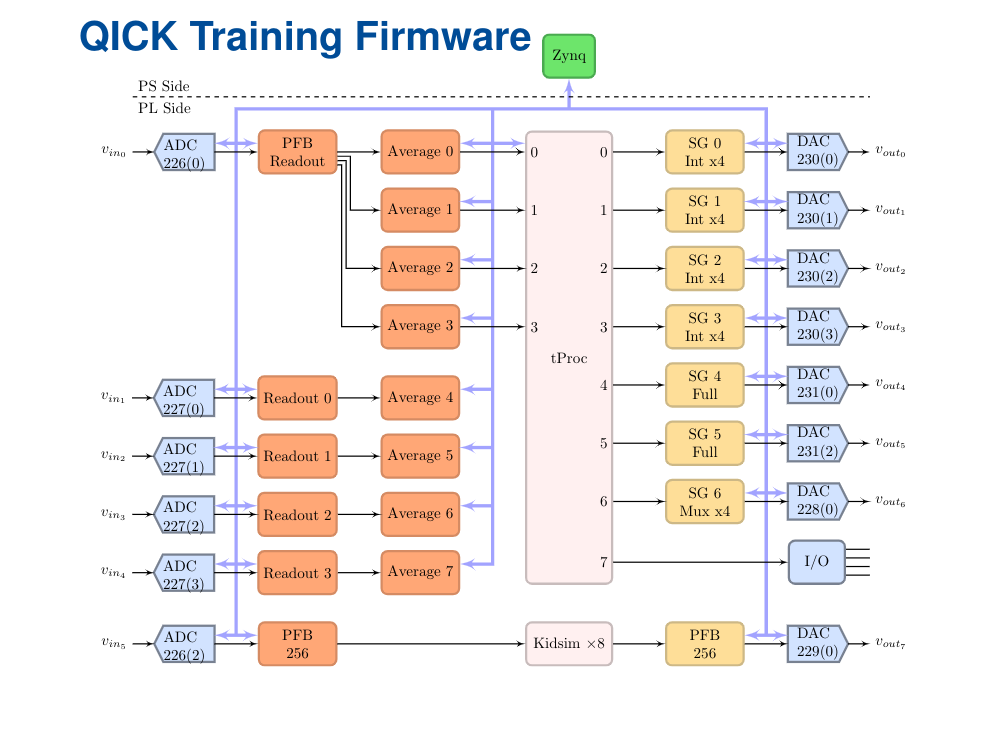

In [3]:
from IPython.display import Image, display
display(Image(filename='images/Qick_training.png', embed=True))

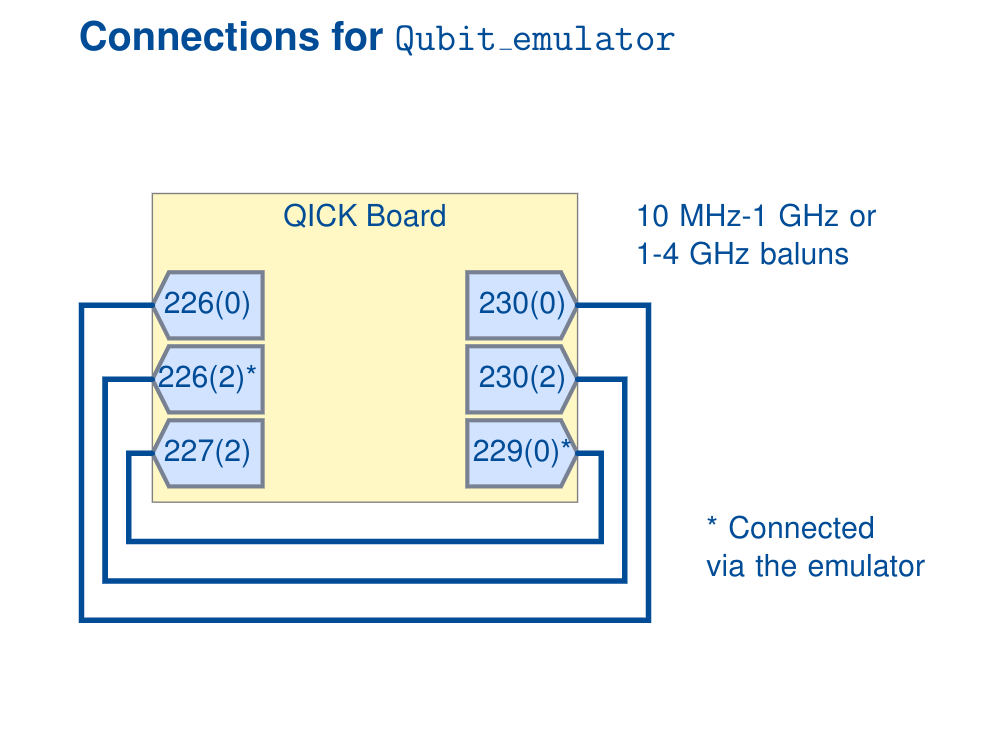

In [4]:
display(Image(filename='images/Connections_Qubit_emulator.png', embed=True))

In [5]:
######################################
### Build Resonator Emulator Chain ###
######################################
simu = SimuChain(soc,soc['simu'][0], name="226_2 <-> 229_0")

# RF superconducting qubit readout 101

# Set up your resonator

This resonator's frequency is 500 MHz. The resonator has a certain internal quality factor, which you will extract by fitting it in a cell below. We have set the resonator up to jump from one frequency to the other in 7 us, in a single step.

In [29]:
###############################
### Resonator Configuration ###
###############################
simu.qout(3)
#simu.synthesis.qout(1)

# Disable all resonators.
simu.alloff()


fr = 500
res_jump_time = 10 #6.2
### Resonator configuration. Note that some of these config parameters depend on each other, 
### so not every configuration is possible.
cfg = {'sel' : 'resonator', 'freq' : fr}
cfg['nstep'] = 1 # 3
cfg['sweep_time'] = res_jump_time # should be a little longer than readout time (5 us)
simu.set_resonator(cfg, verbose=True)

SimuChain: f = 500 MHz, fd = -114.39999999999998 MHz, k = 232, fdds = 0.8000000000000114 MHz
AxisKidsimV3: sel        = resonator
AxisKidsimV3: channel    = 232
AxisKidsimV3: lane       = 0
AxisKidsimV3: punct_id   = 29
AxisKidsimV3: iir_c0     = 0.99
AxisKidsimV3: iir_c1     = 0.8
AxisKidsimV3: iir_g      = 0.9045226130653267
AxisKidsimV3: dds_freq   = 0.8000000000000114
AxisKidsimV3: dds_wait   = 95
AxisKidsimV3: sweep_freq = 0.9
AxisKidsimV3: sweep_time = 10
AxisKidsimV3: nstep      = 1
freq = 5461, bval = 6144, slope = 6144, steps = 1, wait = 95
c0 = 32440, c1 = 26214, g = 29639
sel = 0, punct_id = 29, addr = 0


In [30]:
class ResonatorJump(AveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"], nqz=2, mixer_freq=0)
                        
        # First channel.
        length   = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'])
        freq_gen = self.freq2reg(self.cfg['pulse_freq'], gen_ch=self.cfg['gen_ch'], ro_ch=self.cfg['ro_ch'])
        self.set_pulse_registers(ch     = self.cfg['gen_ch'],
                                     style  = 'const',
                                     length = length,
                                     freq   = freq_gen,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'])
        
        # Readout.
        self.declare_readout(ch      = self.cfg['ro_ch'], 
                             length  = self.us2cycles(self.cfg['ro_length'], ro_ch = self.cfg['ro_ch']),
                             freq    = self.cfg['pulse_freq'],
                             gen_ch  = self.cfg['gen_ch'])        
        
        self.synci(200)  # give processor some time to configure pulses      
    
    def body(self):
        # Trigger.
        self.trigger(adcs=self.ro_chs, pins=[0],adc_trig_offset=0)

        # Pulse.
        self.pulse(ch = self.cfg['gen_ch'], t=0)
        
        # Resonator Jump.
        if self.cfg['do_jump']:
            self.trigger(pins=list(range(4,12)),t=self.us2cycles(self.cfg['trigger_off']))
        

# Resonator spectroscopy

By measuring the complex S_21 of the resonator around its resonant frequency, we can find its resonance and then fit it to find its quality factor. Let's measure this S_21 of our resonator.

In [43]:
# Frequency sweep.
fc = fr
df = 20
fstart = fc - df/2
fstop = fc + df/2
N = 1500
# config={"gen_ch"      : 2,
#         "reps"        : 1,
#         "soft_avgs"   : 1,
#         "pulse_length": 25,
#         "pulse_gain"  : 8000, # [DAC units]
#         "pulse_freq"  : fr, # [MHz]
#         "trigger_off" : 5,
#         "ro_ch"     : 6,
#         "ro_length" : 30,
#         'do_jump' : False
#        }

config={"gen_ch"      : 2,
        "reps"        : 1,
        "pulse_length": 15,
        "pulse_gain"  : 15000, # [DAC units]
        "pulse_freq"  : fr, # [MHz]
        "do_jump"  : True,
        "trigger_off" : 5,
       }

ro_cfg = {
    "ro_ch"     : 6,
    "ro_length" : 10,
    "ro_sel"    : 'product',
    "ro_offset" : 10,
    "soft_avgs" : 1
}

config.update(**ro_cfg)


freqs = np.linspace(start=fstart, stop=fstop, num=N)
print('Sweep Parameters')
print('* fstart = {} MHz'.format(fstart))
print('* fstop  = {} MHz'.format(fstop))
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(freqs[1]-freqs[0]))
iqs = []
for f in tqdm(freqs):
    config['pulse_freq'] = f
    prog = ResonatorJump(soccfg, config)
    iq = prog.acquire(soc, progress=False)
    iqs.append(iq[0][0][0]+1j*iq[1][0][0])
iqs = np.array(iqs)

# plt.semilogy(freqs, np.abs(iqs))

Sweep Parameters
* fstart = 490.0 MHz
* fstop  = 510.0 MHz
* N      = 1500
* fr     = 0.013342228152112057 MHz


  0%|          | 0/1500 [00:00<?, ?it/s]

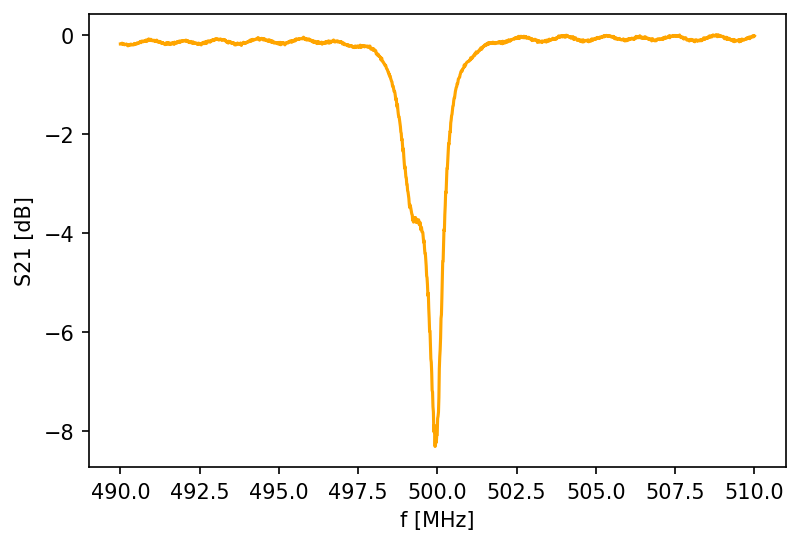

In [44]:
mags = np.abs(iqs)
phi = np.angle(iqs)
S21 = 20*np.log10(mags/np.max(mags))

#############
### Plots ###
#############
plt.figure(dpi=150)
plt.plot(freqs,S21,color='orange')
plt.xlabel('f [MHz]')
plt.ylabel('S21 [dB]');

### Let's fit this resonator to a Lorentzian function and extract its quality factor

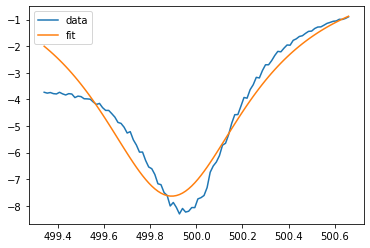

In [45]:
def lorentzian(freq, gamma, center_freq, amplitude):
    return amplitude * gamma**2 / ( gamma**2 + ( freq - center_freq )**2) + 1

guess = [0.0001, 500, -150]
popt, pcov = curve_fit(lorentzian, freqs[700:800], S21[700:800], maxfev = 100000, p0 = guess)
fit_lorentzian = lorentzian(freqs, *popt)
guess_lorentzian = lorentzian(freqs, *guess)
plt.plot(freqs[700:800], S21[700:800], label="data")
plt.plot(freqs[700:800], fit_lorentzian[700:800], label="fit")
plt.legend()

In [46]:
kappa = popt[0] ## Resonator linewidth (gamma of the Lorentzian function)
f = popt[1] ## Resonator center frequency
Qint = f/kappa
print("Resonator quality factor is ~" + str(int(Qint)))

Resonator quality factor is ~1237


This quality factor is somewhat similar to that of the readout resonator in the QICK paper:
https://arxiv.org/abs/2110.00557 Figure 14

In [47]:
kappa = 1e6 ## Resonator linewidth from QICK paper
f = 8.5015e9 ## Resonator center frequency from QICK paper
Qint = f/kappa
print("Resonator quality factor is ~" + str(int(Qint)))

Resonator quality factor is ~8501



The qubit being in a certain state (e.g. the ground state versus the excited state) causes a shift in the frequency of the qubit's readout resonator. This change of frequency causes a change in the complex S_21 of a readout tone transmitted through the fridge. 

When you take a single shot of measurement, by measuring the resonator frequency you can find out the state of the qubit without destroying that state. In general you are discriminating between two blobs, or two trajectories, in IQ space, since you will read out the resonator at two locations (qubit in ground state, vs. qubit in excited state). 

In a real experiment, you might read out at the ground or excited state frequency and look at the transmission amplitude, or read out at the midpoint and look at the phase.

We measure the "readout fidelity" of our qubit system by preparing the qubit in the excited state and in the ground state and looking at the IQ distribution of the resonator in both cases:

# Single shot readout, no T1 decay

In [48]:
#####################################
### No T1 decay ###
#####################################

config={"gen_ch"      : 2,
        "reps"        : 1,
        "pulse_length": 15,
        "pulse_gain"  : 15000, # [DAC units]
        "pulse_freq"  : fr, # [MHz]
        "qubit_jump"  : True,
        "trigger_off" : 5,

       }

ro_cfg = {
    "ro_ch"     : 6,
    "ro_length" : 5,
    "ro_sel"    : 'product',
    "ro_offset" : 10,
    "soft_avgs" : 1
}


config.update(**ro_cfg)

# Number of points.
N = 1000

i_v = np.zeros(N)
q_v = np.zeros(N)
a_v = np.zeros(N)
i0 = []
i1 = []
q0 = []
q1 = []
a0 = []
a1 = []
for i in range(N):
    # Decide if resonator will jump.
    if random()<0.5:
        config['do_jump'] = True
    else:
        config['do_jump'] = False

    # Execute program.
    prog = ResonatorJump(soccfg, config)
    iq = prog.acquire(soc, progress=False)
    xx = iq[0][0][0] + 1j*iq[1][0][0]
    i_v[i] = iq[0][0][0]
    q_v[i] = iq[1][0][0]
    a_v[i] = np.abs(xx)
#     phi_v[i] = np.angle(xx) + gauss(mu=0,sigma=0.05)

    if config['do_jump']:
        i1.append(i_v[i])
        q1.append(q_v[i])
        a1.append(a_v[i])
    else:
        i0.append(i_v[i])
        q0.append(q_v[i])
        a0.append(a_v[i])

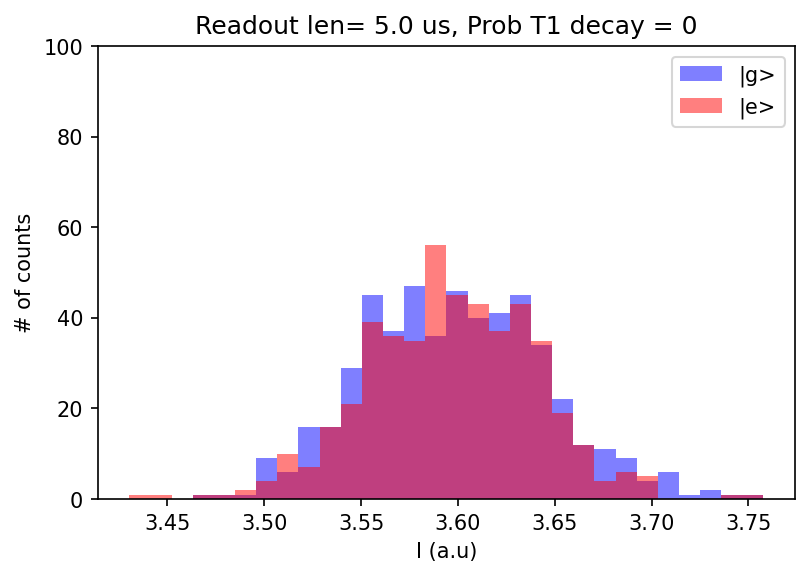

In [49]:

plt.figure(dpi=150)
bins=np.histogram(np.hstack((i0,i1)), bins=30)[1] #get the bin edges
plt.title('Readout len= %.1f us,' %config['ro_length'] + ' Prob T1 decay = 0')
plt.xlabel('I (a.u)')
plt.ylabel('# of counts')
plt.ylim(0,100)
plt.hist(i0, bins,color='b', alpha=0.5,label='|g>')
plt.hist(i1, bins,color='r', alpha=0.5,label='|e>')
plt.legend();

# Single shot readout, small amount of T1 decay

When a qubit decays from its excited state to its ground state, its readout resonator jumps back from “e”to “g” instantaneously at random times given by a Poisson distribution with a time scale set by the qubit’s T1 time. We can specify the amount of T1 decay we want by specifying the probability for the resonator to jump: `prob_t1`

### Try this demo out with more and more T1 decay!

In [38]:
#####################################
### Add a small amount of T1 decay ###
#####################################
prob_t1 = 0.15 #0.15 # 0.4

config={"gen_ch"      : 2,
        "reps"        : 1,
        "pulse_length": 15,
        "pulse_gain"  : 15000, # [DAC units]
        "pulse_freq"  : fr, # [MHz]
        "qubit_jump"  : True
       }

ro_cfg = {
    "ro_ch"     : 6,
    "ro_length" : 5,
    "ro_sel"    : 'product',
    "ro_offset" : 10,
    "soft_avgs" : 1
}

config.update(**ro_cfg)

# Number of points.
N = 1000

i_v = np.zeros(N)
q_v = np.zeros(N)
a_v = np.zeros(N)
i0 = []
i1 = []
q0 = []
q1 = []
a0 = []
a1 = []
for i in range(N):
    # Set resonator jump time.
    t_jump = res_jump_time

    # Decide if resonator will jump.
    if random()<0.5:
        config['qubit_jump'] = True
        # Set T1 decay to happen
        if random()<prob_t1:
            t_jump = 1
    else:
        config['qubit_jump'] = False

    # Set resonator.
#   simu.enable(fr, t=tr, N=1)
    cfg = {'sel' : 'resonator', 'freq' : fr, 'nstep': 1, 'sweep_time': t_jump}
    simu.set_resonator(cfg)
 
    # Execute program.
    prog = VnaProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False)
    xi,xq = res[1].item(),res[2].item()

    xx = xi + 1j*xq
    i_v[i] = xi
    q_v[i] = xq
    a_v[i] = np.abs(xx)
#     phi_v[i] = np.angle(xx) + gauss(mu=0,sigma=0.05)

    if config['qubit_jump']:
        i1.append(i_v[i])
        q1.append(q_v[i])
        a1.append(a_v[i])
    else:
        i0.append(i_v[i])
        q0.append(q_v[i])
        a0.append(a_v[i])

plt.figure(dpi=150)
bins=np.histogram(np.hstack((i0,i1)), bins=30)[1] #get the bin edges
plt.title('Readout len= %.1f us,' %config['ro_length'] + ' Prob T1 decay = %.2f' %prob_t1)
plt.xlabel('I (a.u)')
plt.ylabel('# of counts')
plt.ylim(0,100)
plt.hist(i0, bins, color='b', alpha=0.5,label='|g>')
plt.hist(i1, bins, color='r', alpha=0.5,label='|e>')
plt.legend();

AttributeError: 'list' object has no attribute 'item'

# Rotate data into I quadrature and compute readout fidelity

In [ ]:
#####################################
### Compute readout fidelity with a small amount of T1 decay ###
#####################################

#Convert lists to arrays
i0 = np.array(i0)
q0 = np.array(q0)
i1 = np.array(i1)
q1 = np.array(q1)

plt.figure(dpi=150)
fid, thresh, theta, xlims = hist_process(data=[i0,q0,i1,q1],numbins=30);

plt.figure(dpi=150)
i0_rot = i0 * np.cos(theta) - q0 * np.sin(theta)
i1_rot = i1 * np.cos(theta) - q1 * np.sin(theta)
bins=np.histogram(np.hstack((i0_rot,i1_rot)), bins=30)[1] #get the bin edges
plt.xlabel('I (a.u)')
plt.ylabel('# of counts')
plt.vlines(thresh,ymin=0,ymax=100,color='black',linestyle='--')
plt.hist(i0_rot, bins=30, range=xlims, color='b', alpha=0.5,label='|g>')
plt.hist(i1_rot, bins=30, range=xlims, color='r', alpha=0.5,label='|e>')
plt.title("Threshold I = %.2f"%thresh)
plt.legend();

This threshold value is good until you re-set the resonators or re-set the firmware. Re-running the above two cells will result in distributions with similar thresholds. Re-run `Single shot readout, small amount of T1 decay` cell, first, then this one.

### Questions:
* What `prob_t1` do you need to achieve 50% readout fidelity?
* 100% readout fidelity?
* 25% readout fidelity?
* 0% readout fidelity?

In [ ]:
### Solution:

## 50% readout fidelity, need ~50% prob_t1
## 100% readout fidelity, need 0% prob_t1! 
## 25% readout fidelity, need ~75% prob_t1
## 0% readout fidelity, need ~100% prob_t1

### Before you proceed, recalibrate your single shot readout threshold and theta values with 15% `prob_t1`.

# T1 decay curve

You've already computed the readout fidelity given an amount of T1 decay to obtain `threshold`, `theta` values. Next, choose the `T1` time of your emulated qubit. Then you will be ready to emulate the T1 decay curve.

In [ ]:
#####################################
### Simulate T1 decay curve ###
#####################################

def T1_dist(t,T1):
    p = np.exp(-t/T1)
    return p

#####################################
#####################################

## You've already calibrated your single shot readout
thresh_calib = thresh
theta_calib = theta
print("Calibrated threshold = " + str(thresh_calib) + ", theta = " + str(theta_calib))

## Choose your qubit's T1 
T1 = 2 # a.u.
print("T1 is 2 (in arbitrary units)")

In [ ]:
#####################################
### Now, simulate T1 decay curve using those calibrated values ###
#####################################

N= 100

P_es= []
ts = range(0,10)
# Loop over number of T1 experiments
for t in ts:
    print("wait time (a.u.) = ", t)
    i0 = []
    i1 = []
    q0 = []
    q1 = []
    for i in range(N):
        # Set resonator jump time.
        t_jump = res_jump_time

        # Decide if resonator will jump.
        if random()<0.5:
            config['qubit_jump'] = True
            # Set T1 decay to happen
            if random()>T1_dist(t,T1):
                t_jump = 1
        else:
            config['qubit_jump'] = False

        # Set resonator.
    #   simu.enable(fr, t=tr, N=1)
        cfg = {'sel' : 'resonator', 'freq' : fr, 'nstep': 1, 'sweep_time': t_jump}
        simu.set_resonator(cfg)
    
        # Execute program.
        prog = VnaProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False)
        xi,xq = res[1].item(),res[2].item()

        xx = xi + 1j*xq

        if config['qubit_jump']:
            i1.append(xi)
            q1.append(xq)
        else:
            i0.append(xi)
            q0.append(xq)

    #Convert lists to arrays
    i0 = np.array(i0)
    q0 = np.array(q0)
    i1 = np.array(i1)
    q1 = np.array(q1)
    i0_rot = i0 * np.cos(theta_calib) - q0 * np.sin(theta_calib)
    i1_rot = i1 * np.cos(theta_calib) - q1 * np.sin(theta_calib)
    e_counts = 0
    g_counts = 0
    for x in i1_rot:
        if x < thresh_calib:
            g_counts +=1
        else:
            e_counts +=1
#     print("e, g counts = ", e_counts, g_counts)
    P_e = 1-g_counts/(g_counts+e_counts)
#     print("P_e = ", P_e)
    P_es.append(P_e)

In [ ]:
plt.figure(dpi=150)
plt.plot(ts,P_es,'.',label='Emulated')
plt.ylabel('$ P_e $')
plt.xlabel("Time (a.u.)")
plt.legend()
plt.title("Emulated T1 decay")
plt.tight_layout();

Fit the data of this curve to an exponential decay using the `curve_fit` function. Overlay the fit to the data.

In [ ]:
def exponential(x, a, b, c, d):
    return a * np.exp(- (x - b) / c) + d

def decaying_cosine(x, a, b, c, d, e):
    return a * np.exp(-x / e) * np.cos(2. * np.pi * b * x + c * np.pi / 180.) + d

def cosine(x, a, b, c, d):
    return a * np.cos(2. * np.pi * b * x - c * 2 * np.pi) + d


In [ ]:
## Solution:

a_guess = np.max(P_es)-np.min(P_es)
b_guess = 0
c_guess = ts[-1]/10
d_guess = np.min(P_es)

guess=[a_guess, b_guess, c_guess, d_guess]
popt, pcov = curve_fit(exponential, ts, P_es, maxfev = 100000, p0 = guess)
fit_exponential = exponential(ts, *popt)

plt.figure(dpi=150)
plt.plot(ts,P_es,'.',label='Emulated')
plt.plot(ts,fit_exponential,'-',color='red',label="Fit")
plt.ylabel('$ P_e $')
plt.xlabel("Time (a.u.)")
plt.legend()
plt.title("Emulated T1 decay")
plt.tight_layout();

### What is the T1 of this decay curve according to your fit? What is the error on your fitted T1? 

In [ ]:
## Solution:
popt[2] ## T1
np.sqrt(pcov[2][2]) ## Error

# Rabi oscillations

Similarly, we can use our previously calibrated readout values to emulate qubit Rabi oscillations.

In [ ]:
#####################################
### Simulate Rabi oscillation ###
#####################################

def Rabi_dist(t,Omega):
    p = -0.5*np.cos(Omega*t)+0.5
    return p

#####################################
### Now, simulate Rabi oscillation using the previously calibrated readout values ###
#####################################

N= 100

thresh_calib = thresh
theta_calib = theta
Omega = 0.5

print('Experiment Parameters')
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(fr))
print('* Omega     = {} (a.u.)'.format(Omega))


P_es= []
ts = range(0,10)
# Loop over number of Rabi experiments
for t in ts:
    print("wait time (a.u.) = ", t)
    i0 = []
    i1 = []
    q0 = []
    q1 = []
    for i in range(N):
        # Set resonator jump time.
        t_jump = res_jump_time

        # Decide if resonator will jump.
        if random()<0.5:
            config['qubit_jump'] = True
            if random()>Rabi_dist(t,Omega):
                t_jump = 1
        else:
            config['qubit_jump'] = False

        # Set resonator.
    #   simu.enable(fr, t=tr, N=1)
        cfg = {'sel' : 'resonator', 'freq' : fr, 'nstep': 1, 'sweep_time': t_jump}
        simu.set_resonator(cfg)
 
    
        # Execute program.
        prog = VnaProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False)
        xi,xq = res[1].item(),res[2].item()

        xx = xi + 1j*xq

        if config['qubit_jump']:
            i1.append(xi)
            q1.append(xq)
        else:
            i0.append(xi)
            q0.append(xq)

    #Convert lists to arrays
    i0 = np.array(i0)
    q0 = np.array(q0)
    i1 = np.array(i1)
    q1 = np.array(q1)
    i0_rot = i0 * np.cos(theta_calib) - q0 * np.sin(theta_calib)
    i1_rot = i1 * np.cos(theta_calib) - q1 * np.sin(theta_calib)
    e_counts = 0
    g_counts = 0
    for x in i1_rot:
        if x < thresh_calib:
            g_counts +=1
        else:
            e_counts +=1
#     print("e, g counts = ", e_counts, g_counts)
    P_e = 1-g_counts/(g_counts+e_counts)
#     print("P_e = ", P_e)
    P_es.append(P_e)

In [ ]:
plt.figure(dpi=150)
plt.plot(ts,P_es,'.',label='Emulated')
plt.ylabel('$ P_e $')
plt.xlabel("Time (a.u.)")
plt.legend()
plt.title("Emulated Rabi oscillation")
plt.tight_layout();

Fit the data of this curve to a cosine using the `curve_fit` function. Overlay the fit to the data.

In [ ]:
## Solution:

a_guess = -(np.max(P_es) - np.min(P_es)) / 2
b_guess = 1/ts[-1]
c_guess = 0
d_guess = np.mean(P_es)

guess=[a_guess, b_guess, c_guess, d_guess]
popt, pcov = curve_fit(cosine, ts, P_es, maxfev = 100000, p0 = guess)
fit_cosine = cosine(ts, *popt)

plt.figure(dpi=150)
plt.plot(ts,P_es,'.',label='Emulated')
plt.plot(ts, fit_cosine,'-',color='red',label="Fit")
plt.ylabel('$ P_g $')
plt.xlabel("Time (a.u.)")
plt.legend()
plt.title("Emulated Rabi oscillation")
plt.tight_layout();

### How long do you have to drive to do a pi pulse? What's the error on that, according to your fit?

In [ ]:
## Solution:
1/(2*popt[1]) ## Drive time
#np.sqrt(pcov[1][1]) ## Error

### How about a pi/2 pulse?

In [ ]:
## Solution:
1/(4*popt[1]) ## Drive time
#np.sqrt(pcov[1][1]) ## Error

# Ramsey fringes

Similarly, we can use our previously calibrated readout values to emulate qubit Rabi oscillations.

In [ ]:
#####################################
### Simulate Rabi oscillation ###
#####################################

def T2R_dist(t,T2R,Detuning):
    p = 0.5*np.exp(-t/T2R)*np.cos(Detuning*t)+0.5
    return p

#####################################
### Now, simulate Ramsey fringes using the previously calibrated readout values ###
#####################################

N= 100

thresh_calib = thresh
theta_calib = theta
Detuning = 10 # Detuning
T2R = 6

print('Experiment Parameters')
print('* N      = {}'.format(N))
print('* fr     = {} MHz'.format(fr))
print('* Detuning     = {} (a.u.)'.format(Omega))
print('* T2R     = {} (a.u.)'.format(T2R))


P_es= []
ts = np.arange(0,13,0.5)
# Loop over number of Rabi experiments
for t in ts:
    print("wait time (a.u.) = ", t)
    i0 = []
    i1 = []
    q0 = []
    q1 = []
    for i in range(N):
        # Set resonator jump time.
        t_jump = res_jump_time

        # Decide if resonator will jump.
        if random()<0.5:
            config['qubit_jump'] = True
            if random()>T2R_dist(t,T2R,Detuning):
                t_jump = 1
        else:
            config['qubit_jump'] = False

        # Set resonator.
    #   simu.enable(fr, t=tr, N=1)
        cfg = {'sel' : 'resonator', 'freq' : fr, 'nstep': 1, 'sweep_time': t_jump}
        simu.set_resonator(cfg)
 
    
        # Execute program.
        prog = VnaProgram(soccfg, config)
        res = prog.acquire(soc, load_pulses=True, progress=False)
        xi,xq = res[1].item(),res[2].item()

        xx = xi + 1j*xq

        if config['qubit_jump']:
            i1.append(xi)
            q1.append(xq)
        else:
            i0.append(xi)
            q0.append(xq)

    #Convert lists to arrays
    i0 = np.array(i0)
    q0 = np.array(q0)
    i1 = np.array(i1)
    q1 = np.array(q1)
    i0_rot = i0 * np.cos(theta_calib) - q0 * np.sin(theta_calib)
    i1_rot = i1 * np.cos(theta_calib) - q1 * np.sin(theta_calib)
    e_counts = 0
    g_counts = 0
    for x in i1_rot:
        if x < thresh_calib:
            g_counts +=1
        else:
            e_counts +=1
#     print("e, g counts = ", e_counts, g_counts)
    P_e = 1-g_counts/(g_counts+e_counts)
#     print("P_e = ", P_e)
    P_es.append(P_e)

In [ ]:
plt.figure(dpi=150)
plt.plot(ts,P_es,'.',label='Emulated')
plt.ylabel('$ P_e $')
plt.xlabel("Time (a.u.)")
plt.legend()
plt.title("Emulated Ramsey fringes")
plt.tight_layout();

Fit the data of this curve to a decaying cosine using the `curve_fit` function. Overlay the fit to the data.

In [ ]:
## Solution:

a_guess = (np.max(P_es) - np.min(P_es)) / 2
b_guess = 5 # Give them hints about the detuning and what that means
c_guess = 0
d_guess = np.mean(P_es)
e_guess = ts[-1]/4

guess=[a_guess, b_guess, c_guess, d_guess, e_guess]
popt, pcov = curve_fit(decaying_cosine, ts, P_es, maxfev = 100000, p0 = guess)
fit_decaying_cosine = decaying_cosine(ts, *popt)

plt.figure(dpi=150)
plt.plot(ts,P_es,'.',label='Emulated')
plt.plot(ts, fit_decaying_cosine,'-',color='red',label="Fit")
plt.ylabel('$ P_e $')
plt.xlabel("Time (a.u.)")
plt.legend()
plt.title("Emulated Ramsey fringes")
plt.tight_layout();